In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import polyfit, polyval, array, linspace, argwhere
from CoolProp.CoolProp import PropsSI
from math import exp

In [2]:
df = pd.read_csv(r'C:\Users\kevak\hw6.csv')

In [212]:
# Initial Conditions
power = df.to_numpy()
size = [0.125,5.0000E-01,5.0000E-01,5.0000E-01,1.0000E+00,5.0000E-01,5.0000E-01,1.0000E+00,1.0000E+00,5.0000E-01,5.0000E-01,1.0000E+00,1.0000E+00,1.0000E+00,5.0000E-01,5.0000E-01,1.0000E+00,1.0000E+00,1.0000E+00,1.0000E+00,5.0000E-01,5.0000E-01,1.0000E+00,1.0000E+00,1.0000E+00,1.0000E+00,1.0000E+00,5.0000E-01,1.0000E+00,1.0000E+00,1.0000E+00]
heights = [21,21,21,20,20,20,20,20,20,20,20,20,20,20,20,21,21,21]
mdottotal = 2325
pi=np.pi
Tin=562.25 #289.1+273.15
Pin=15.6E6
assemblies=193
L=3.66
Le = L*1.2 #Extrapolated length for finding qprime
Axialstep = L/40
z=-L/2+Axialstep
rods=264
guides=25
Dfo=.819/100
D=.95/100
R_co=D/2
R_ci=Dfo/2;
Pitch=1.26/100
pd=Pitch/D
GtubeOD=1.224
K=.5628
water = 'IF97::Water'

In [213]:
#solves for fuel centerline temp
def Tmaxsolver(T_fo, qprimez2):
# cant do a sensitivty study with this
#     M1 = 3824 * np.log(402.4 + T_fo) + (6.1256E-11) / 4 * pow(T_fo + 273, 4)
#     T_max_guess = 300
#     qprimez_guess = 0
#     while (abs(qprimez2 - qprimez_guess)>0.01):
#         M2 = 3824 * np.log(402.4 + T_max_guess) + (6.1256E-11) / 4 * (T_max_guess + 273)**4
#         qprimez_guess = 4 * pi*(M2 - M1)
#         T_max_guess = T_max_guess + 0.01
#     return T_max_guess
    segN = 5                       # number of radial segments
    Router, Touter = R_ci, T_fo     # Temperature at the surface (at Rf)
    idx = 1
    area = pi*R_ci**2               # area of surface to convert q' to q'''
    powerdensity = qprimez2/area    # Equation implies power density is bulk rather than segmented and reevaluated
    while (idx < segN + 1):
        if Router <0:
            Router=0
        tempC=Touter-273.15
#         print("tempc", tempC)
        kf = 1/(0.1148+(2.475E-4)*tempC)+0.0132*exp(0.00188*tempC)       # W/mK
#         print("kf touter r outer", kf, Touter, Router)
        Rinner = Router-(R_ci/segN)
        Tinner = (Touter+powerdensity/4*(Router**2-Rinner**2)/kf)
        idx += 1                                    # continue to the next ring
        Touter=Tinner
        Router=Rinner
    return Touter

In [186]:
#base code for iterations
def MCA(mdottuner):
    #Lists to store axial values
    dPspacer=0
    Tcoolantlist = []
    Tcilist = []
    Tcolist = []
    Tmaxlist = []
    dPtotallist = []
    dPgravlist = []
    dPfriclist = []
    dPaccellist = []
    dPspacerlist = []
    tunercounter=0
    for i in range(31):
        #Channel properties
        channelpower = power[:,i]
        D_h = D*(4/pi*pd**2-1)
        mdot = mdottotal*size[i]/24.125/(289*size[i])+mdottuner[tunercounter]
        A = (Pitch**2-pi/4*D**2)
        #print("mdot, Area", mdot, A)
        #print("Dh", D_h)
        G = mdot/A
        #print("G", G)
        #Lists to store axial channel values
        Tcoolant = []
        Tci = []
        Tco = []
        Tmax = []
        dPtotal = [0]
        dpgrav = []
        dpfric = []
        dpaccel = []
        dpspacer = []
        z=-L/2+Axialstep
        Tin=562.25
        segment, counter = -L/2 , 0 #counter for adding spacer dP
        tunercounter+=1
        segmentLoc=-L/2+(heights[0]/100) #segment 1 lasts up to 21 cm
        segmentnumber=0 #tracks current axial power segment for indexing
        while z <= (L/2):
            percent3=1
            percent4=1-percent3
            if z>segmentLoc: #updates the current segment with z
                if z-Axialstep<segmentLoc:       #uses previously stored segmentLoc prior to updating for calculating qprime at dz-0.5step
                    percent3=(z-segmentLoc)/Axialstep
                    percent4=1-percent3
                if segmentnumber<17:
                    segmentnumber+=1
                    segmentLoc+=heights[segmentnumber]/100
            if z<segmentLoc: #if z stretches across axial power segments, power must be averaged
                percent1=(segmentLoc-z)/Axialstep
                percent2=1-percent1
            if z<segmentLoc and z+Axialstep<segmentLoc: #same segment
                percent1=1
                percent2=1-percent1
            qprimez2 = channelpower[segmentnumber]/(heights[segmentnumber]/100)/(289*size[i])*percent1
            if segmentnumber < 17:
                qprimez2+=channelpower[segmentnumber+1]/(heights[segmentnumber+1]/100)/(289*size[i])*percent2 #linear power at axial step
            if segmentLoc > -L/2+heights[0]: #prevents indexing below 0 on the first run
                qprime = channelpower[segmentnumber]/(heights[segmentnumber]/100)/(289*size[i])*percent3+channelpower[segmentnumber-1]/(heights[segmentnumber-1]/100)/(289*size[i])*percent4          #linear power at -.5 axial step
            else: #first run
                qprime = channelpower[segmentnumber]/(heights[segmentnumber]/100)/(289*size[i])*percent3
            #print (qprime, qprimez2)
            #properties evaluated at inlet temp
            h_fin = PropsSI("H", "T", Tin, "P", (Pin-sum(dPtotal)), water)
            rhoin = PropsSI("D", "T", Tin, "P", (Pin-sum(dPtotal)), water)
            vol_fin = 1/rhoin
        
            #Temp calc at midway to axial step
            h_f = h_fin+(qprime*(Axialstep))/mdot
           # print("Tin",Tin)
            Tin = PropsSI("T", "H", h_f, "P", (Pin-sum(dPtotal)), water)
            #print("Tin @ +1/2 step",Tin)
            #property calcs
            mu_f = PropsSI("V", "T", Tin, "P", (Pin-sum(dPtotal)), water)
            k_f = PropsSI("L", "T", Tin, "P", (Pin-sum(dPtotal)), water)
            Pr_f = PropsSI("Prandtl", "T", Tin, "P", (Pin-sum(dPtotal)), water)
            rho = PropsSI("D", "T", Tin, "P", (Pin-sum(dPtotal)), water)
            vol_f = 1/rho
            Re=G*D_h/mu_f
            Nu=(.023*(Re**.8)*(Pr_f ** .333)*(1.826*Pitch/D-1.0430))
            htc=Nu*k_f/D_h
            #print("Re Nu htc",Re, Nu, htc)
            #Termperatures
            T_co=qprimez2/(2*pi*R_co*htc)+Tin
            k_c = 12.767 - 5.4348E-4*Tin+8.918E-6*Tin**2
            T_ci=qprimez2/(2*pi*k_c)*np.log(R_co/R_ci)+T_co
            T_fo = T_ci #no gap considered
            T_max = Tmaxsolver(T_fo, qprimez2)
        
            #Pressure drops
            dPfric=(D_h*G/mu_f)**-.18*(.1339+.09059*((Pitch/D)-1)-.09926*((Pitch/D)-1)**2)*G**2*vol_f/(D_h*2)*(Axialstep)
            dPaccel=G**2*abs((vol_f-vol_fin))
            dPgrav=9.81/vol_f*(Axialstep)
            #print ("f a g vfin vf", dPfric, dPaccel, dPgrav, vol_fin, vol_f)
            V = G/rho
            if counter<9 and dPspacer==0 and z>segment:
                dPspacer=K*rho*V**2/2
                counter+=1
                segment+=L/9
            else:
                dPspacer=0
            dP=dPgrav+dPfric+dPaccel+dPspacer
        
        #adding single channel values to lists
            Tcoolant.append(Tin)
            Tci.append(T_ci)
            Tco.append(T_co)
            Tmax.append(T_max)
            dpgrav.append(dPgrav)
            dpfric.append(dPfric)
            dpaccel.append(dPaccel)
            dpspacer.append(dPspacer)
            dPtotal.append(dP)
        
        #advancing axially
            z+=Axialstep
    
    # compiling list of channels
        Tcoolantlist.append(Tcoolant)
        Tcilist.append(Tci)
        Tcolist.append(Tco)
        Tmaxlist.append(Tmax)
        dPgravlist.append(dpgrav)
        dPfriclist.append(dpfric)
        dPaccellist.append(dpaccel)
        dPspacerlist.append(dpspacer)
        dPtotallist.append(sum(dPtotal))
    return dPtotallist

In [214]:
#converges channel dP by adjusting flow rates
def tuner():
    Abserror = 1000000
    errorlist = []
    mdottuner=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    while Abserror > 30:
        dPtotallist = MCA(mdottuner)
        avgdP = (sum(dPtotallist)/len(dPtotallist))
        for i in range(31):
            error = dPtotallist[i]-avgdP
            errorlist.append(error)
        Abserror = sum(map(abs, errorlist))
        print("ABS", Abserror)
        for i in range(31):
            if errorlist[i] > 1:
                mdottuner[i]-=0.000001
            elif errorlist[i] < -1:
                mdottuner[i]+=0.000001
        errorlist=[]
    return mdottuner
    

In [216]:
# redundant annotated code implementing functions above to make vairbales global so they can be plotted
dPspacer=0
Tcoolantlist = []
Tcilist = []
Tcolist = []
Tmaxlist = []
dPtotallist = []
dPgravlist = []
dPfriclist = []
dPaccellist = []
dPspacerlist = []
tunercounter=0
mdottuner = tuner()
for i in range(31):
    #Channel properties
    channelpower = power[:,i]
    D_h = D*(4/pi*pd**2-1) #hydarulic diamater
    mdot = mdottotal*size[i]/24.125/(289*size[i])+mdottuner[tunercounter]
    A = (Pitch**2-pi/4*D**2)
    #print("mdot, Area", mdot, A)
    #print("Dh", D_h)
    G = mdot/A
    #print("G", G)
    #Lists to store axial channel values
    Tcoolant = []
    Tci = []
    Tco = []
    Tmax = []
    dPtotal = [0] #so zero pressure is subtracted the first time
    dpgrav = []
    dpfric = []
    dpaccel = []
    dpspacer = []
    z=-L/2+Axialstep #position starts at +1 step and subtracts to 1/2 step
    Tin=562.25
    segment, counter = -L/2 , 0 #counter for adding spacer dP
    tunercounter+=1 #indexes array to modify next channel mdot
    segmentLoc=-L/2+(heights[0]/100) #segment 1 lasts up to 21 cm
    segmentnumber=0 #tracks current axial power segment for indexing
    while z < (L/2):
        percent3=1 # for averaging down segments
        percent4=1-percent3
        if z>segmentLoc: #updates the current segment with z
            if z-Axialstep<segmentLoc:       #uses previously stored segmentLoc prior to updating for calculating qprime at dz-0.5step
                percent3=(z-segmentLoc)/Axialstep
                percent4=1-percent3
            if segmentnumber<17:
                segmentnumber+=1 
                segmentLoc+=heights[segmentnumber]/100
        if z<segmentLoc: #if z stretches across axial power segments, power must be averaged
            percent1=(segmentLoc-z)/Axialstep
            percent2=1-percent1
        if z<segmentLoc and z+Axialstep<segmentLoc: #same segment
            percent1=1
            percent2=1-percent1
        qprimez2 = channelpower[segmentnumber]/(heights[segmentnumber]/100)/(289*size[i])*percent1 #linear heat gen at z
        if segmentnumber < 17:
            qprimez2+=channelpower[segmentnumber+1]/(heights[segmentnumber+1]/100)/(289*size[i])*percent2 #linear power at axial step
        if segmentLoc > -L/2+heights[0]: #prevents indexing below 0 on the first run
            qprime = channelpower[segmentnumber]/(heights[segmentnumber]/100)/(289*size[i])*percent3+channelpower[segmentnumber-1]/(heights[segmentnumber-1]/100)/(289*size[i])*percent4          #linear power at -.5 axial step
        else: #first run
            qprime = channelpower[segmentnumber]/(heights[segmentnumber]/100)/(289*size[i])*percent3
        #print (qprime, qprimez2)
        #print (segmentnumber)
        
        #properties evaluated at inlet temp
        h_fin = PropsSI("H", "T", Tin, "P", (Pin-sum(dPtotal)), water)
        rhoin = PropsSI("D", "T", Tin, "P", (Pin-sum(dPtotal)), water)
        vol_fin = 1/rhoin
        
        #Temp calc at midway to axial step
        h_f = h_fin+(qprime*(Axialstep))/mdot
        #print("Tin",Tin)
        Tin = PropsSI("T", "H", h_f, "P", (Pin-sum(dPtotal)), water)
        #print("Tin @ +1/2 step",Tin)
        
        #property calcs
        mu_f = PropsSI("V", "T", Tin, "P", (Pin-sum(dPtotal)), water)
        k_f = PropsSI("L", "T", Tin, "P", (Pin-sum(dPtotal)), water)
        Pr_f = PropsSI("Prandtl", "T", Tin, "P", (Pin-sum(dPtotal)), water)
        rho = PropsSI("D", "T", Tin, "P", (Pin-sum(dPtotal)), water)
        vol_f = 1/rho
        Re=G*D_h/mu_f
        Nu=(.023*(Re**.8)*(Pr_f ** .333)*(1.826*Pitch/D-1.0430))
        htc=Nu*k_f/D_h #heat transfer coefficient of coolant
        #print("Re Nu htc",Re, Nu, htc)
        
        #Termperatures
        T_co=qprimez2/(2*pi*R_co*htc)+Tin
        k_c = 12.767 - 5.4348E-4*Tin+8.918E-6*Tin**2
        T_ci=qprimez2/(2*pi*k_c)*np.log(R_co/R_ci)+T_co
        T_fo = T_ci #no gap considered
        T_max = Tmaxsolver(T_fo, qprimez2)
        
        #Pressure drops
        dPfric=(D_h*G/mu_f)**-.18*(.1339+.09059*((Pitch/D)-1)-.09926*((Pitch/D)-1)**2)*G**2*vol_f/(D_h*2)*(Axialstep)
        dPaccel=G**2*abs((vol_f-vol_fin))
        dPgrav=9.81/vol_f*(Axialstep)
        #print ("f a g vfin vf", dPfric, dPaccel, dPgrav, vol_fin, vol_f)
        V = G/rho
        if counter<9 and dPspacer==0 and z>segment:
            dPspacer=K*rho*V**2/2
            counter+=1
            segment+=L/9
        else:
            dPspacer=0
        dP=dPgrav+dPfric+dPaccel+dPspacer
        
        #adding single channel values to lists
        Tcoolant.append(Tin)
        Tci.append(T_ci)
        Tco.append(T_co)
        Tmax.append(T_max)
        dpgrav.append(dPgrav)
        dpfric.append(dPfric)
        dpaccel.append(dPaccel)
        dpspacer.append(dPspacer)
        dPtotal.append(dP)
        
        #advancing axially
        z+=Axialstep
    
    # compiling list of channels
    Tcoolantlist.append(Tcoolant)
    Tcilist.append(Tci)
    Tcolist.append(Tco)
    Tmaxlist.append(Tmax)
    dPgravlist.append(dpgrav)
    dPfriclist.append(dpfric)
    dPaccellist.append(dpaccel)
    dPspacerlist.append(dpspacer)
    dPtotallist.append(sum(dPtotal))


ABS 21359.829498539344
ABS 21343.195857365194
ABS 21326.562216058854
ABS 21309.92857462776
ABS 21293.294933066092
ABS 21276.66129137184
ABS 21260.027649549447
ABS 21243.394007603187
ABS 21226.760365524402
ABS 21210.126723315436
ABS 21193.49308097799
ABS 21176.859438513173
ABS 21160.22579591589
ABS 21143.592153191174
ABS 21126.958510335506
ABS 21110.324867356816
ABS 21093.691224241906
ABS 21077.05758100086
ABS 21060.423937631887
ABS 21043.79029413317
ABS 21027.156650501987
ABS 21010.523006747055
ABS 20993.88936285743
ABS 20977.25571884426
ABS 20960.622074699495
ABS 20943.988430425234
ABS 20927.354786023207
ABS 20910.72114149104
ABS 20894.087496829234
ABS 20877.45385203966
ABS 20860.820207124198
ABS 20844.18656207397
ABS 20827.552916898363
ABS 20810.91927159013
ABS 20794.285626153563
ABS 20777.651980591574
ABS 20761.01833489853
ABS 20744.38468907615
ABS 20727.751043128024
ABS 20711.1173970464
ABS 20694.48375083707
ABS 20677.850104501937
ABS 20661.216458033596
ABS 20644.58281143864
ABS 20

ABS 15928.773727139996
ABS 15915.45254009201
ABS 15902.13135964844
ABS 15888.810185810478
ABS 15875.48901858028
ABS 15862.167857952867
ABS 15848.846703934905
ABS 15835.525556522873
ABS 15822.863264643602
ABS 15810.200977595
ABS 15797.538695375973
ABS 15784.876417991778
ABS 15771.382366565595
ABS 15758.304096587293
ABS 15744.810323188925
ABS 15731.732126293937
ABS 15719.069873067056
ABS 15706.407624671207
ABS 15693.74538110834
ABS 15681.083142378717
ABS 15668.420908478787
ABS 15655.758679410108
ABS 15643.096455171515
ABS 15630.434235768422
ABS 15617.772021194702
ABS 15604.69403327971
ABS 15591.199822048686
ABS 15577.706109222083
ABS 15564.704251544768
ABS 15552.106732759523
ABS 15539.509221054672
ABS 15526.911716415765
ABS 15514.314218857835
ABS 15501.716728373649
ABS 15489.119244966176
ABS 15476.521768630453
ABS 15463.92429937188
ABS 15451.32683718871
ABS 15438.729382079022
ABS 15425.369465963173
ABS 15412.39068754857
ABS 15399.031031586434
ABS 15386.052325453667
ABS 15373.454905720326

ABS 11577.633557031237
ABS 11566.52511074947
ABS 11555.416673701577
ABS 11544.308245879016
ABS 11533.19982729308
ABS 11522.091417936725
ABS 11510.98301781244
ABS 11499.874626916237
ABS 11488.766245256193
ABS 11477.657872821408
ABS 11466.549509618286
ABS 11455.441155648281
ABS 11443.639633806713
ABS 11432.18461573853
ABS 11420.729953266506
ABS 11408.928682749538
ABS 11397.473600196725
ABS 11385.325458576743
ABS 11374.217169219046
ABS 11363.108889096766
ABS 11352.000618203514
ABS 11340.892356541255
ABS 11329.784104109101
ABS 11318.675860910473
ABS 11307.567626941687
ABS 11296.459402203996
ABS 11285.351186697706
ABS 11274.242980418829
ABS 11263.134783372341
ABS 11252.026595559917
ABS 11240.9184169754
ABS 11229.81024762355
ABS 11218.702087503421
ABS 11207.593936612917
ABS 11196.485794953565
ABS 11185.031166689121
ABS 11173.576360361782
ABS 11162.121562898756
ABS 11150.667121035367
ABS 11138.5192945233
ABS 11126.371362408725
ABS 11115.263285364432
ABS 11104.155217556006
ABS 11093.0471589732

ABS 7942.607341269555
ABS 7933.437402716387
ABS 7924.267473780317
ABS 7914.542963434811
ABS 7904.540980014761
ABS 7894.5392233371385
ABS 7884.260407491718
ABS 7874.8129073918535
ABS 7865.643036143898
ABS 7856.473174512881
ABS 7847.303322493506
ABS 7838.13348009286
ABS 7828.686425952896
ABS 7818.6842500597995
ABS 7808.405483274997
ABS 7798.1267509694735
ABS 7788.956956642898
ABS 7779.509551948271
ABS 7770.339776852037
ABS 7761.170011366819
ABS 7752.000255499996
ABS 7742.830509248088
ABS 7733.10617859647
ABS 7723.104373379683
ABS 7713.102794902079
ABS 7702.824155757902
ABS 7693.376836848678
ABS 7684.207148286005
ABS 7675.037469342977
ABS 7665.867800009815
ABS 7656.698140292079
ABS 7647.2512673435995
ABS 7636.972173756076
ABS 7626.970679570819
ABS 7616.692123971487
ABS 7607.5225123306445
ABS 7598.075288827924
ABS 7588.905696417147
ABS 7579.736113621228
ABS 7570.56654043826
ABS 7561.119753279039
ABS 7551.117839882092
ABS 7541.116780773344
ABS 7530.5608612912765
ABS 7521.391336180954
ABS 75

ABS 5182.479232967176
ABS 5176.39196967044
ABS 5170.305262751252
ABS 5164.045271971292
ABS 5157.611721238893
ABS 5150.83236907603
ABS 5144.745507968182
ABS 5138.831839807142
ABS 5132.744677524126
ABS 5126.658034001375
ABS 5120.225128295191
ABS 5113.618683440363
ABS 5107.012090847304
ABS 5101.098475015606
ABS 5095.011364597827
ABS 5088.924772930404
ABS 5082.491918143947
ABS 5075.885523747391
ABS 5069.278981610885
ABS 5063.539090628852
ABS 5057.451991711161
ABS 5051.364790824591
ABS 5045.451564002215
ABS 5039.364685365625
ABS 5033.1047121054435
ABS 5026.844697749635
ABS 5020.931375136453
ABS 5015.364528444334
ABS 5009.797691019572
ABS 5004.057189873143
ABS 4998.316826306458
ABS 4992.5763840489235
ABS 4986.662916338537
ABS 4980.7497905208875
ABS 4974.663012424906
ABS 4968.403139237533
ABS 4962.143224957472
ABS 4956.230003350574
ABS 4950.663258601082
ABS 4945.096523115411
ABS 4939.529796901057
ABS 4933.789406501033
ABS 4928.0491536782065
ABS 4922.3088221680955
ABS 4916.395464729314
ABS 491

ABS 3380.117590303518
ABS 3376.2523762120254
ABS 3372.283546140912
ABS 3368.1069350999605
ABS 3363.9297906346183
ABS 3360.168793154953
ABS 3356.303784176009
ABS 3352.127043887507
ABS 3347.846366063066
ABS 3343.981114031456
ABS 3340.1161294982303
ABS 3335.9394128126587
ABS 3331.6587583099317
ABS 3327.7935307249427
ABS 3323.928570638818
ABS 3319.751877555609
ABS 3315.4712463762844
ABS 3311.6060432394443
ABS 3307.741107597947
ABS 3303.6685749320022
ABS 3299.492199422617
ABS 3295.730845829734
ABS 3291.761923395752
ABS 3287.68920346495
ABS 3283.3048796869843
ABS 3279.5435508219816
ABS 3275.5746525549475
ABS 3271.501956506181
ABS 3267.117655769427
ABS 3263.3563516334107
ABS 3259.491315059524
ABS 3255.4188535738067
ABS 3251.2421452583367
ABS 3247.1692482610524
ABS 3243.3042361356056
ABS 3239.231798533947
ABS 3235.05511382081
ABS 3230.982240707206
ABS 3227.1172530290787
ABS 3223.0448393080587
ABS 3218.8681782011554
ABS 3214.7953289751604
ABS 3211.0345604219183
ABS 3207.065832645283
ABS 3202.78

ABS 2042.9447755207948
ABS 2040.2276453980885
ABS 2037.0947112773429
ABS 2034.3081500838744
ABS 2031.591032733253
ABS 2028.4581102625234
ABS 2025.6715616535075
ABS 2022.9544570726284
ABS 2019.8215462499502
ABS 2017.0350102243247
ABS 2014.3179184173787
ABS 2011.1850192437705
ABS 2008.3984958036453
ABS 2005.6814167663688
ABS 2002.5485292404628
ABS 1999.76201838399
ABS 1997.0449521195114
ABS 1993.9120762406383
ABS 1991.1255779709609
ABS 1988.4085244744929
ABS 1985.3451010228018
ABS 1982.6279517802177
ABS 1979.8416122454219
ABS 1976.7087222190457
ABS 1973.991585747266
ABS 1971.2747535255476
ABS 1968.0723804187292
ABS 1965.355256719733
ABS 1962.6384372658795
ABS 1959.4360756252572
ABS 1956.7189646986517
ABS 1954.0021580150496
ABS 1950.7998078349628
ABS 1948.0827096803987
ABS 1945.3659157664515
ABS 1942.1635770489665
ABS 1939.446491665527
ABS 1936.7297105243779
ABS 1933.5273832685198
ABS 1930.8103106585186
ABS 1928.0935422831972
ABS 1924.8912264919782
ABS 1922.1741666511662
ABS 1919.52672450

ABS 1010.0064593817224
ABS 1006.9438519315881
ABS 1004.1587906850182
ABS 1001.4438256321446
ABS 998.4507022580656
ABS 995.526638896059
ABS 992.8116866114724
ABS 989.8185752628051
ABS 986.8945241139736
ABS 984.1795846017194
ABS 981.1864852765866
ABS 978.2624463374814
ABS 975.5475195950276
ABS 972.5544322937785
ABS 969.6304055687942
ABS 966.9154915961117
ABS 963.9224163174076
ABS 960.9984018055547
ABS 958.2835006015521
ABS 955.2904373470956
ABS 952.3664350484323
ABS 949.6515466124838
ABS 946.6584953833371
ABS 943.7345052964374
ABS 941.0196296310896
ABS 938.0265904282132
ABS 935.1026125538774
ABS 932.3877496571367
ABS 930.4739325517876
ABS 928.4903667236795
ABS 926.6465365769545
ABS 924.7289631499152
ABS 923.230800371748
ABS 921.628524938802
ABS 920.0607207895955
ABS 918.4585203675524
ABS 916.8211336119712
ABS 915.1843149751512
ABS 913.5469318185787
ABS 911.875414459937
ABS 910.2381151281152
ABS 908.5318354718038
ABS 906.8946109040844
ABS 905.1881412331568
ABS 903.620430413197
ABS 901.913

ABS 344.73271887519513
ABS 343.1307976778917
ABS 341.5288342683052
ABS 339.92691695096437
ABS 338.32495742120955
ABS 336.72304398205597
ABS 335.15583971155866
ABS 333.588536221243
ABS 332.1601609510253
ABS 330.6624884029152
ABS 329.1298587589263
ABS 327.59735716211435
ABS 326.0648157786345
ABS 324.636451793951
ABS 323.13879015948623
ABS 321.67561531614047
ABS 320.2126331010659
ABS 318.7843239779759
ABS 317.2863491429598
ABS 315.7886167795077
ABS 314.29086050056503
ABS 312.8971661341493
ABS 311.4340702211339
ABS 309.9363036860741
ABS 308.54273443827697
ABS 307.0797184655821
ABS 305.5817855611094
ABS 304.18815791727684
ABS 302.7599651141936
ABS 301.2620389655349
ABS 299.8684183539299
ABS 298.4402324897528
ABS 296.9423130930518
ABS 295.58351602609036
ABS 294.120520593322
ABS 292.6226079518965
ABS 291.26381801007665
ABS 289.800829422471
ABS 288.3029235347494
ABS 286.9441407192353
ABS 285.481158979921
ABS 283.98325984379335
ABS 282.62448415473045
ABS 281.1615092621214
ABS 279.66361688163306

Text(0.5, 0, 'Temp [K]')

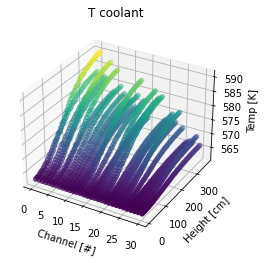

In [210]:
Channel=[]
Height=[]
Temp=[]
for i in range(31):
    for j in range (len(Tcoolant)):
        Channel.append(i)
for i in range(31):
    height=Axialstep*100
    for j in range (len(Tcoolant)):
        Height.append(height)
        height+=Axialstep*100
for i in range(31):
    for j in range (len(Tcoolant)):
        Temp.append(Tcoolantlist[i][j])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=Channel, ys=Height, zs=Temp, c=Temp)
ax.set_title("T coolant")
ax.set_xlabel('Channel [#]')
ax.set_ylabel('Height [cm]')
ax.set_zlabel('Temp [K]')

Text(0.5, 0, 'Height [cm]')

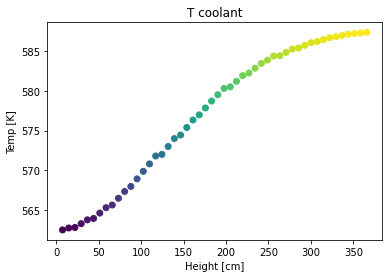

In [211]:
Height=[]
Temp=[]
height=Axialstep*100
for j in range (len(Tcoolant)):
        Height.append(height)
        height+=Axialstep*100
for j in range (len(Tcoolant)):
    Temp.append(Tcoolantlist[4][j])
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Height, Temp, c=Temp)
ax.set_title("T coolant")
ax.set_ylabel('Temp [K]')
ax.set_xlabel('Height [cm]')

Text(0.5, 0, 'Temp [K]')

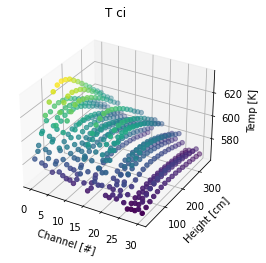

In [194]:
Channel=[]
Height=[]
Temp=[]
for i in range(31):
    for j in range (len(Tcoolant)):
        Channel.append(i)
for i in range(31):
    height=Axialstep*100
    for j in range (len(Tcoolant)):
        Height.append(height)
        height+=Axialstep*100
for i in range(31):
    for j in range (len(Tcoolant)):
        Temp.append(Tcilist[i][j])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=Channel, ys=Height, zs=Temp, c=Temp)
ax.set_title("T ci")
ax.set_xlabel('Channel [#]')
ax.set_ylabel('Height [cm]')
ax.set_zlabel('Temp [K]')

Text(0.5, 0, 'Height [cm]')

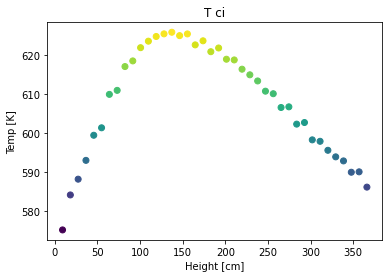

In [220]:
Height=[]
Temp=[]
height=Axialstep*100
for j in range (len(Tcoolant)):
        Height.append(height)
        height+=Axialstep*100
for j in range (len(Tcoolant)):
    Temp.append(Tcilist[4][j])
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Height, Temp, c=Temp)
ax.set_title("T ci")
ax.set_ylabel('Temp [K]')
ax.set_xlabel('Height [cm]')

Text(0.5, 0, 'Temp [K]')

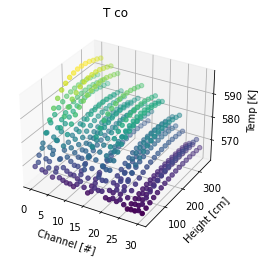

In [196]:
Channel=[]
Height=[]
Temp=[]
for i in range(31):
    for j in range (len(Tcoolant)):
        Channel.append(i)
for i in range(31):
    height=Axialstep*100
    for j in range (len(Tcoolant)):
        Height.append(height)
        height+=Axialstep*100
for i in range(31):
    for j in range (len(Tcoolant)):
        Temp.append(Tcolist[i][j])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=Channel, ys=Height, zs=Temp, c=Temp)
ax.set_title("T co")
ax.set_xlabel('Channel [#]')
ax.set_ylabel('Height [cm]')
ax.set_zlabel('Temp [K]')

Text(0.5, 0, 'Height [cm]')

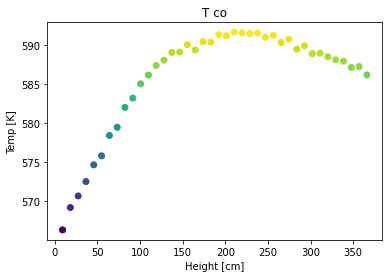

In [219]:
Height=[]
Temp=[]
height=Axialstep*100
for j in range (len(Tcoolant)):
        Height.append(height)
        height+=Axialstep*100
for j in range (len(Tcoolant)):
    Temp.append(Tcolist[4][j])
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Height, Temp, c=Temp)
ax.set_title("T co")
ax.set_ylabel('Temp [K]')
ax.set_xlabel('Height [cm]')

Text(0.5, 0, 'Temp [K]')

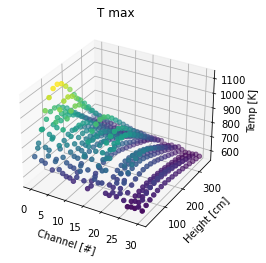

In [198]:
Channel=[]
Height=[]
Temp=[]
for i in range(31):
    for j in range (len(Tcoolant)):
        Channel.append(i)
for i in range(31):
    height=Axialstep*100
    for j in range (len(Tcoolant)):
        Height.append(height)
        height+=Axialstep*100
for i in range(31):
    for j in range (len(Tcoolant)):
        Temp.append(Tmaxlist[i][j])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=Channel, ys=Height, zs=Temp, c=Temp)
ax.set_title("T max")
ax.set_xlabel('Channel [#]')
ax.set_ylabel('Height [cm]')
ax.set_zlabel('Temp [K]')

Text(0.5, 0, 'Height [cm]')

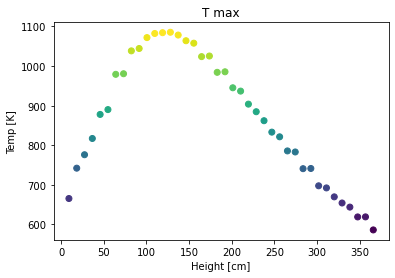

In [218]:
Height=[]
Temp=[]
height=Axialstep*100
for j in range (len(Tcoolant)):
        Height.append(height)
        height+=Axialstep*100
for j in range (len(Tcoolant)):
    Temp.append(Tmaxlist[4][j])
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Height, Temp, c=Temp)
ax.set_title("T max")
ax.set_ylabel('Temp [K]')
ax.set_xlabel('Height [cm]')

In [134]:
print(dpaccel)

[4.689916116300614, 8.91714541093564, 12.349544469701446, 15.478146691839527, 17.759068166256334, 19.48485779675207, 20.14038235409931, 20.235111838023798, 19.494506044557756, 17.998920912798862, 16.422660427332346, 14.235135180327806, 12.207116642679841, 10.131996813277327, 7.930818337716637, 5.63485183963942, 3.6605788437277433]


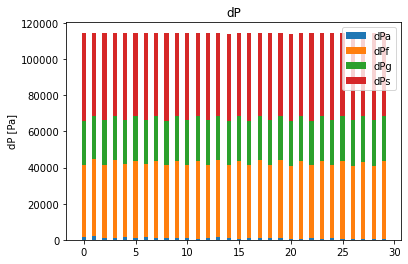

In [200]:
Channel=[]
dPa=[]
dPf=[]
dPg=[]
dPs=[]
for i in range(30):
    Channel.append(i)
for i in range(30):
    dPa.append(sum(dPaccellist[i]))
    dPf.append(sum(dPfriclist[i]))
    dPg.append(sum(dPgravlist[i]))
    dPs.append(sum(dPspacerlist[i]))

fig, ax = plt.subplots()
width =.4
q = np.add(dPa,dPf)
ax.bar(Channel, dPa, width, label='dPa')
ax.bar(Channel, dPf, width, bottom=dPa, label='dPf')
ax.bar(Channel, dPg, width, bottom=q, label='dPg')
ax.bar(Channel, dPs, width, bottom=np.add(q,dPg), label='dPs')

ax.set_ylabel('dP [Pa]')
ax.set_title('dP')
ax.legend()

plt.show()

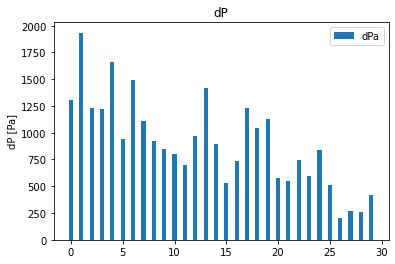

In [201]:
fig, ax = plt.subplots()
width =.4
ax.bar(Channel, dPa, width, label='dPa')
ax.set_ylabel('dP [Pa]')
ax.set_title('dP')
ax.legend()

plt.show()

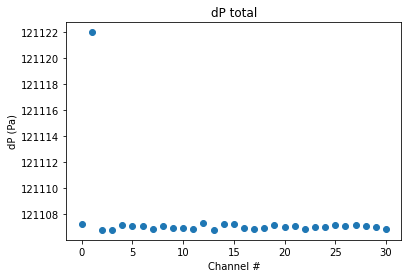

In [217]:
Channel=[]
for i in range(31):
    Channel.append(i)
plt.title("dP total")
plt.ylabel("dP (Pa)")
plt.xlabel("Channel #")
plt.scatter(Channel, dPtotallist)
plt.ticklabel_format(useOffset=False)

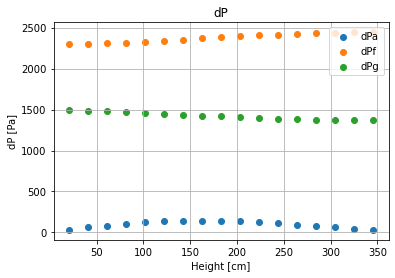

In [203]:
Height=[]
height=Axialstep*100
for j in range (len(Tcoolant)):
        Height.append(height)
        height+=Axialstep*100
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Height, dPaccellist[4], label='dPa')
ax.scatter(Height, dPfriclist[4], label='dPf')
ax.scatter(Height, dPgravlist[4], label='dPg')
ax.set_title("dP")
ax.set_ylabel('dP [Pa]')
ax.set_xlabel('Height [cm]')
plt.grid()
ax.legend()

In [221]:
print(mdottuner)

[-0.00106200000000001, -0.0031790000000000975, -0.0007550000000000117, -0.0005800000000000075, -0.002346999999999987, 0.00044300000000000426, -0.001715999999999955, -0.00017699999999999964, 0.00043800000000000414, 0.0008060000000000131, 0.0009110000000000156, 0.0013789999999999833, 0.00024699999999999944, -0.0012819999999999915, 0.0005420000000000067, 0.0019889999999999396, 0.0011370000000000037, -0.0005940000000000078, -4.000000000000036e-06, -0.00021399999999999954, 0.0017589999999999514, 0.0019309999999999369, 0.0011010000000000067, 0.0017529999999999519, 0.0007680000000000122, 0.002043999999999947, 0.0031640000000000956, 0.0029440000000000664, 0.0029830000000000715, 0.0024269999999999977, 0.0030660000000000825]
